In [1]:
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import pyfolio as pf
import numpy as np

/usr/local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


<IPython.core.display.Javascript object>


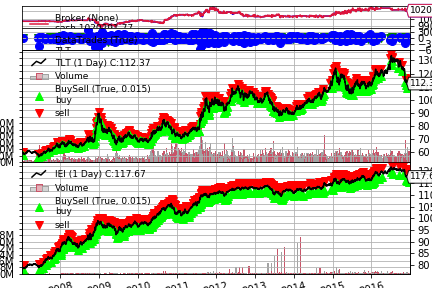

[[<Figure size 432x288 with 6 Axes>]]

In [2]:
class KalmanPair(bt.Strategy):
    params = (("printlog", False), ("quantity", 1000))

    def log(self, txt, dt=None, doprint=False):
        """Logging function for strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.delta = 0.0001
        self.Vw = self.delta / (1 - self.delta) * np.eye(2)
        self.Ve = 0.001

        self.beta = np.zeros(2)
        self.P = np.zeros((2, 2))
        self.R = np.zeros((2, 2))

        self.position_type = None  # long or short
        self.quantity = self.params.quantity

    def next(self):

        x = np.asarray([self.data0[0], 1.0]).reshape((1, 2))
        y = self.data1[0]

        self.R = self.P + self.Vw  # state covariance prediction
        yhat = x.dot(self.beta)  # measurement prediction

        Q = x.dot(self.R).dot(x.T) + self.Ve  # measurement variance

        e = y - yhat  # measurement prediction error

        K = self.R.dot(x.T) / Q  # Kalman gain

        self.beta += K.flatten() * e  # State update
        self.P = self.R - K * x.dot(self.R)

        sqrt_Q = np.sqrt(Q)

        if self.position:
            if self.position_type == "long" and e > -sqrt_Q:
                self.close(self.data0)
                self.close(self.data1)
                self.position_type = None
            if self.position_type == "short" and e < sqrt_Q:
                self.close(self.data0)
                self.close(self.data1)
                self.position_type = None

        else:
            if e < -sqrt_Q:
                self.sell(data=self.data0, size=(self.quantity * self.beta[0]))
                self.buy(data=self.data1, size=self.quantity)

                self.position_type = "long"
            if e > sqrt_Q:
                self.buy(data=self.data0, size=(self.quantity * self.beta[0]))
                self.sell(data=self.data1, size=self.quantity)
                self.position_type = "short"

        self.log(f"beta: {self.beta[0]}, alpha: {self.beta[1]}")



cerebro = bt.Cerebro()
cerebro.addstrategy(KalmanPair)

startdate = datetime(2007, 1, 1)
enddate = datetime(2017, 1, 1)

ewa = bt.feeds.YahooFinanceData(dataname="TLT", fromdate=startdate, todate=enddate)
ewc = bt.feeds.YahooFinanceData(dataname="IEI", fromdate=startdate, todate=enddate)

cerebro.adddata(ewa)
cerebro.adddata(ewc)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio') 
cerebro.broker.setcash(100_0000.0)
results = cerebro.run()
cerebro.plot()

Start date,2007-01-03
End date,2016-12-30
Total months,119
,Backtest
Annual return,0.2%
Cumulative returns,2.0%
Annual volatility,0.6%
Sharpe ratio,0.31
Calmar ratio,0.11
Stability,0.68
Max drawdown,-1.8%


<IPython.core.display.Javascript object>


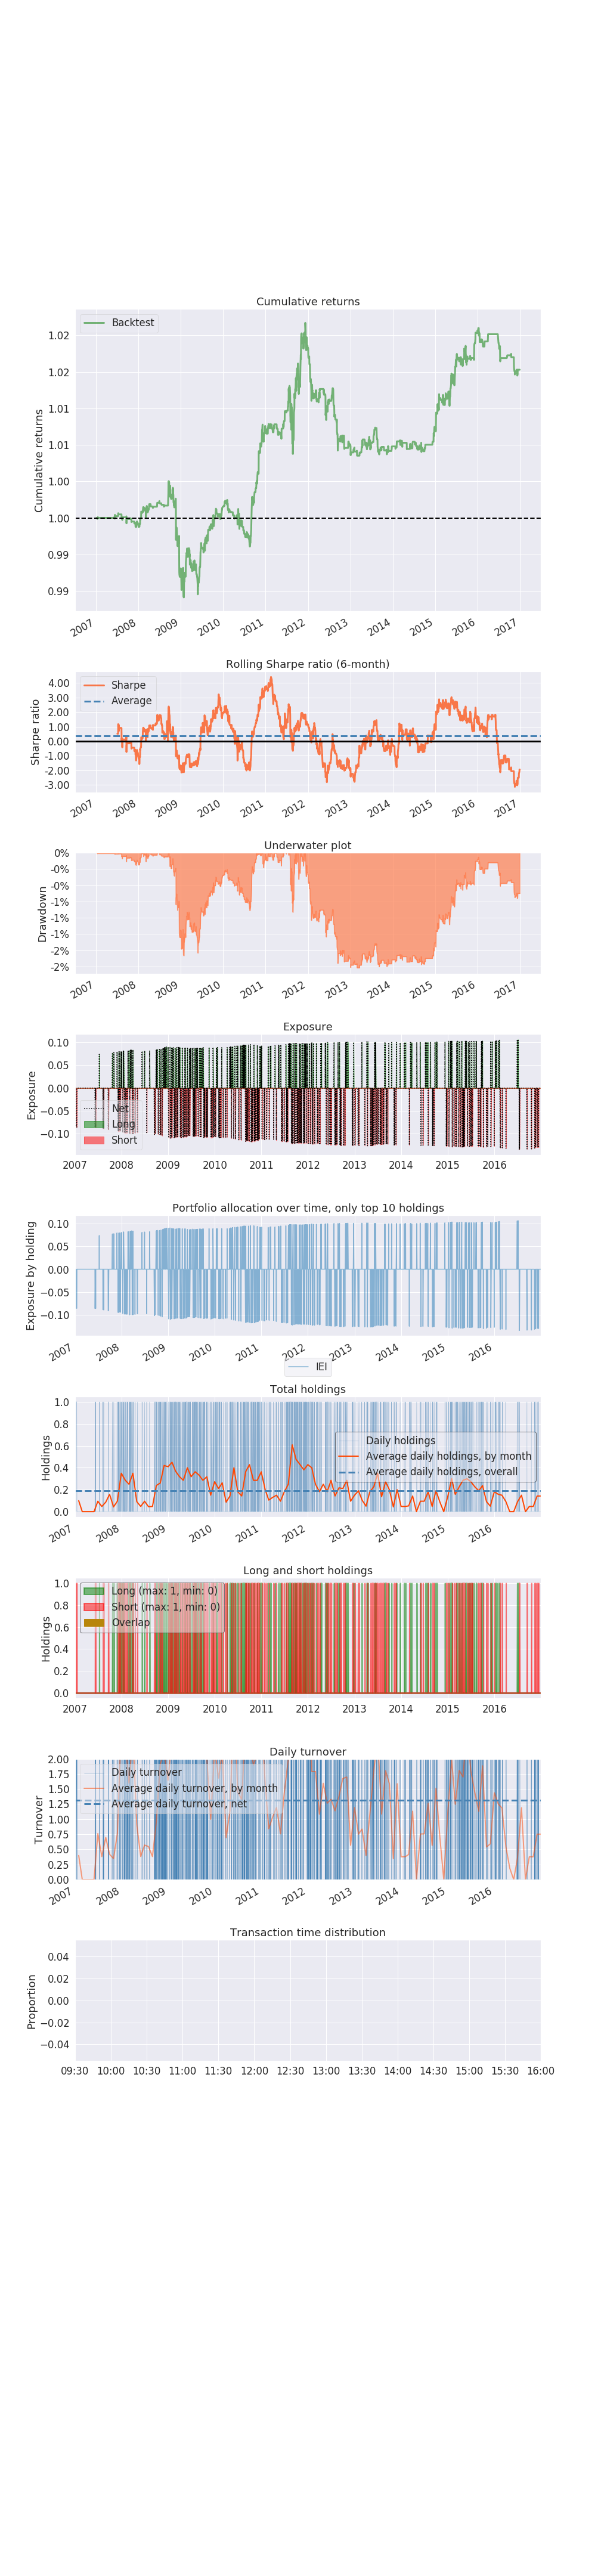

In [3]:

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_simple_tear_sheet(returns, positions=positions, transactions=transactions)